# Training the model using image embeddings

### Reading the spectrogram features

In [128]:
import pandas as pd
all_data = pd.read_csv(r'unsupervised_features/spectrogram_features_google_vite.csv')
all_data = pd.read_csv(r'C:\Users\Adnane\Desktop\Radar\ObjectClassificationWithRadar\Training_with_transfer_learning\unsupervised_features\spectrogram_features_google_vite_torso_removal.csv')

In [129]:
#display max column width
pd.set_option('display.max_colwidth', None)

# Extracting the labels of the data

In [130]:
import pandas as pd
import re
import os

# Assuming 'df' is your pandas DataFrame
# For example:
# df = pd.DataFrame({'image_path': ['/path/to/1P24A01R2_spectrogram.png']})

# If already loaded:
df = all_data.copy()

# Function to extract the first number from the filename only
def extract_first_number_from_filename(path):
    filename = os.path.basename(path)  # Extracts just the filename
    match = re.search(r'(\d+)', filename)  # Looks for the first digit sequence
    if match:
        return int(match.group(1))  # Returns the number as an integer
    return None  # If no number is found

# Apply the function to the 'image_path' column and create the 'label' column
df['label'] = df['image_path'].apply(extract_first_number_from_filename)

# Display the DataFrame with the new 'label' column
print(df[['image_path', 'label']].head())

# To see the full DataFrame with the new column:
# print(df.head())


                                                                                                                       image_path  \
0  /content/drive/Shareddrives/Radar/spectrograms_torso_removed/5 February 2019 UoG Dataset/1P01A01R01_torso_removed_centered.png   
1  /content/drive/Shareddrives/Radar/spectrograms_torso_removed/5 February 2019 UoG Dataset/2P06A02R02_torso_removed_centered.png   
2  /content/drive/Shareddrives/Radar/spectrograms_torso_removed/5 February 2019 UoG Dataset/3P01A03R03_torso_removed_centered.png   
3  /content/drive/Shareddrives/Radar/spectrograms_torso_removed/5 February 2019 UoG Dataset/3P14A03R01_torso_removed_centered.png   
4  /content/drive/Shareddrives/Radar/spectrograms_torso_removed/5 February 2019 UoG Dataset/4P09A04R02_torso_removed_centered.png   

   label  
0      1  
1      2  
2      3  
3      3  
4      4  


# Splitting the data in train,test and validation set

In [131]:
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ['image_path', 'label']), df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

#split in validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Standardizing the data

In [132]:
#standardize the features
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
#initialize the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Performing PCA to reduce dimensionality from 1151 down to 100

In [133]:
#perform PCA on the training data
from sklearn.decomposition import PCA
pca = PCA(n_components=768)  # Reduce to 2 dimensions for visualization
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Training

## Random Forest Classifier

In [134]:
#train the model
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = 8)
# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=8, random_state=42)

### Calculating the accuracy

In [135]:
y_pred = rf_classifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
# Generate the classification report
print(classification_report(y_test, y_pred))
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
#accuraccy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

              precision    recall  f1-score   support

           1       0.98      1.00      0.99        62
           2       0.59      0.60      0.60        63
           3       0.52      0.55      0.54        62
           4       0.72      0.50      0.59        62
           5       0.64      0.77      0.70        62
           6       0.90      0.93      0.91        40

    accuracy                           0.71       351
   macro avg       0.73      0.73      0.72       351
weighted avg       0.72      0.71      0.71       351

[[62  0  0  0  0  0]
 [ 0 38 17  0  5  3]
 [ 0 15 34  3 10  0]
 [ 1  8 10 31 12  0]
 [ 0  3  4  6 48  1]
 [ 0  0  0  3  0 37]]
Accuracy: 0.71


### Plotting the feature importance of the top 10 features

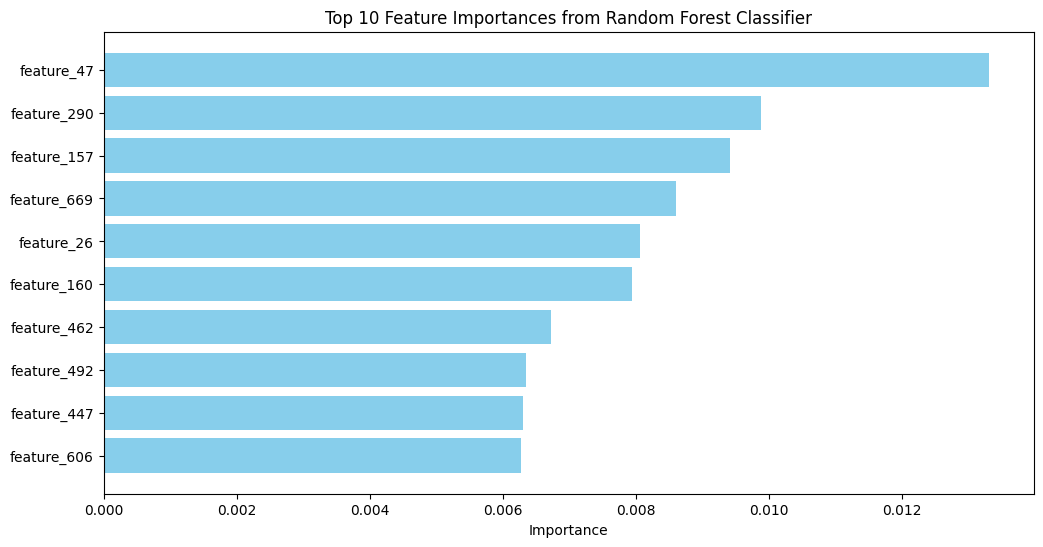

In [136]:
#plot the feature importances
import matplotlib.pyplot as plt
import numpy as np
# Get feature importances from the trained model
importances = rf_classifier.feature_importances_
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 feature importances
top_n = 10
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'][:top_n], feature_importances['Importance'][:top_n], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

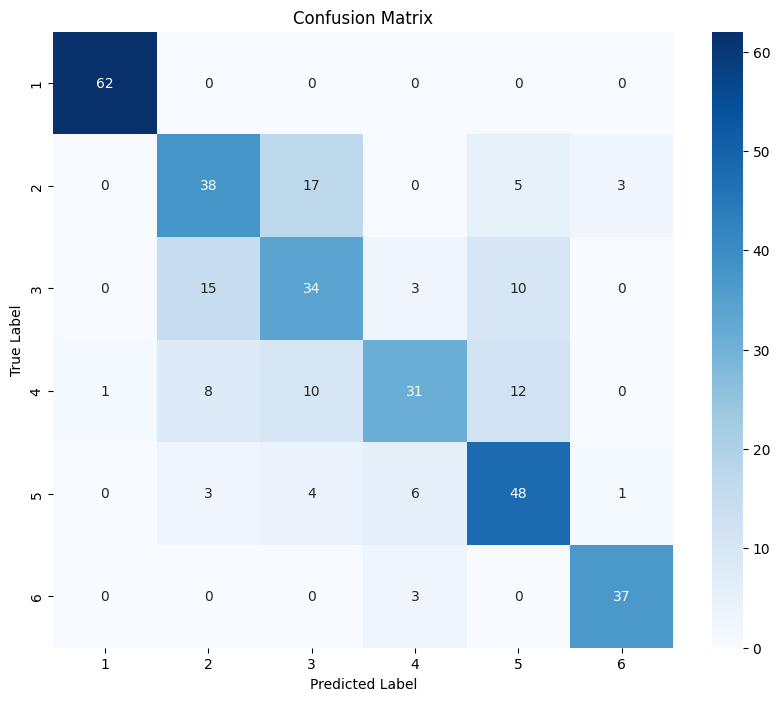

In [137]:
#confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Neural network

In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy

# Assuming y_train, y_val, y_test, X_train_pca, X_val_pca, X_test_pca are pre-defined
# Example placeholder data (replace with your actual data)
# y_labels = ["walking", "sitting_down", "standing_up", "pick_object", "drink_water", "fall"]
# X_dummy = np.random.rand(100, 50)
# y_dummy = np.random.choice(y_labels, 100)
# X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_dummy, y_dummy, test_size=0.2, stratify=y_dummy)
# X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_train_pca, y_train, test_size=0.25, stratify=y_train)

# Encode labels to start from 0 using LabelEncoder
le = LabelEncoder()
# Fit on all unique labels across all sets to ensure consistency
all_labels_for_fitting = np.unique(np.concatenate([y_train, y_val, y_test]))
le.fit(all_labels_for_fitting)

# Transform all label sets
y_train_encoded = le.transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Define number of classes
num_classes = len(le.classes_)

# Debug: Check label ranges
print("Unique values in y_train:", np.unique(y_train_encoded))
print("Unique values in y_val:", np.unique(y_val_encoded))
print("Unique values in y_test:", np.unique(y_test_encoded))
print("num_classes:", num_classes)
print("Class mapping:", {i: label for i, label in enumerate(le.classes_)})

# Combine train and validation sets for k-fold cross validation
X_train_val_combined = np.vstack([X_train_pca, X_val_pca])
y_train_val_combined = np.concatenate([y_train_encoded, y_val_encoded])

print(f"Combined train+val shape: {X_train_val_combined.shape}")
print(f"Combined train+val labels shape: {y_train_val_combined.shape}")

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Check for NaNs/Infs in input tensors
print("X_train_val_combined has NaNs:", np.isnan(X_train_val_combined).any())
print("X_train_val_combined has Infs:", np.isinf(X_train_val_combined).any())
print("X_test has NaNs:", np.isnan(X_test_pca).any())
print("X_test has Infs:", np.isinf(X_test_pca).any())

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation here, as CrossEntropyLoss expects logits
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# K-Fold Cross Validation with Stratification
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store results from each fold
fold_results = {
    'train_losses': [],
    'val_losses': [],
    'val_accuracies': [],
    'best_epochs': []
}

print(f"\nStarting {k_folds}-Fold Stratified Cross Validation")
print("=" * 60)

# Perform k-fold cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_combined, y_train_val_combined)):
    print(f"\nFold {fold + 1}/{k_folds}")
    print("-" * 30)
    
    # Split data for this fold
    X_fold_train = X_train_val_combined[train_idx]
    X_fold_val = X_train_val_combined[val_idx]
    y_fold_train = y_train_val_combined[train_idx]
    y_fold_val = y_train_val_combined[val_idx]
    
    # Convert to tensors
    X_fold_train_tensor = torch.tensor(X_fold_train, dtype=torch.float32)
    X_fold_val_tensor = torch.tensor(X_fold_val, dtype=torch.float32)
    y_fold_train_tensor = torch.tensor(y_fold_train, dtype=torch.long)
    y_fold_val_tensor = torch.tensor(y_fold_val, dtype=torch.long)
    
    # Check stratification
    print(f"Train set class distribution: {np.bincount(y_fold_train)}")
    print(f"Val set class distribution: {np.bincount(y_fold_val)}")
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_fold_train_tensor, y_fold_train_tensor)
    val_dataset = TensorDataset(X_fold_val_tensor, y_fold_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize model for this fold
    input_size = X_fold_train.shape[1]
    model = SimpleNN(input_size, num_classes)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training parameters
    num_epochs = 1000  # Reduced for k-fold to manage time
    patience = 30
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_val_accuracy = 0.0
    
    # Training loop for this fold
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    
    # Store fold results
    fold_results['train_losses'].append(epoch_loss)
    fold_results['val_losses'].append(best_val_loss)
    fold_results['val_accuracies'].append(best_val_accuracy)
    fold_results['best_epochs'].append(epoch + 1 - early_stopping_counter)
    
    print(f"Fold {fold + 1} - Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_val_accuracy:.4f}")

# Print k-fold cross validation results
print("\n" + "=" * 60)
print("K-FOLD CROSS VALIDATION RESULTS")
print("=" * 60)
print(f"Average Validation Loss: {np.mean(fold_results['val_losses']):.4f} ± {np.std(fold_results['val_losses']):.4f}")
print(f"Average Validation Accuracy: {np.mean(fold_results['val_accuracies']):.4f} ± {np.std(fold_results['val_accuracies']):.4f}")
print(f"Average Best Epoch: {np.mean(fold_results['best_epochs']):.1f} ± {np.std(fold_results['best_epochs']):.1f}")

for i, (loss, acc, epoch) in enumerate(zip(fold_results['val_losses'], 
                                          fold_results['val_accuracies'], 
                                          fold_results['best_epochs'])):
    print(f"Fold {i+1}: Val Loss = {loss:.4f}, Val Acc = {acc:.4f}, Best Epoch = {epoch}")

# Train final model on full training+validation data
print("\n" + "=" * 60)
print("TRAINING FINAL MODEL ON FULL TRAIN+VAL DATA")
print("=" * 60)

# Convert combined data to tensors
X_train_val_tensor = torch.tensor(X_train_val_combined, dtype=torch.float32)
y_train_val_tensor = torch.tensor(y_train_val_combined, dtype=torch.long)

# Create final training dataset
final_train_dataset = TensorDataset(X_train_val_tensor, y_train_val_tensor)
final_train_loader = DataLoader(final_train_dataset, batch_size=32, shuffle=True)

# Initialize final model
final_model = SimpleNN(input_size, num_classes)
final_model.to(device)

final_criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=0.001)

# Use average best epoch from k-fold as training epochs for final model
final_epochs = int(np.mean(fold_results['best_epochs']))
print(f"Training final model for {final_epochs} epochs (based on k-fold average)")

# Train final model
for epoch in range(final_epochs):
    final_model.train()
    running_loss = 0.0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        final_optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = final_criterion(outputs, labels)
        loss.backward()
        final_optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(final_train_loader.dataset)
    
    if (epoch + 1) % 50 == 0 or epoch == final_epochs - 1:
        print(f'Final Model Epoch [{epoch+1}/{final_epochs}], Loss: {epoch_loss:.4f}')

# Evaluate final model on test set
print("\n" + "=" * 60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

final_model.eval()
test_loss = 0.0
test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        loss = final_criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        
        # Collect predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(X_test_tensor)
test_accuracy = test_correct / len(X_test_tensor)

print(f'Final Model Test Loss: {test_loss:.4f}')
print(f'Final Model Test Accuracy: {test_accuracy:.4f}')



Unique values in y_train: [0 1 2 3 4 5]
Unique values in y_val: [0 1 2 3 4 5]
Unique values in y_test: [0 1 2 3 4 5]
num_classes: 6
Class mapping: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6}
Combined train+val shape: (1403, 768)
Combined train+val labels shape: (1403,)
X_train_val_combined has NaNs: False
X_train_val_combined has Infs: False
X_test has NaNs: False
X_test has Infs: False
Using device: cuda

Starting 5-Fold Stratified Cross Validation

Fold 1/5
------------------------------
Train set class distribution: [200 199 200 199 198 126]
Val set class distribution: [50 50 49 50 50 32]
Early stopping triggered at epoch 34
Fold 1 - Best Val Loss: 0.5616, Best Val Acc: 0.7936

Fold 2/5
------------------------------
Train set class distribution: [200 200 199 199 198 126]
Val set class distribution: [50 49 50 50 50 32]
Early stopping triggered at epoch 34
Fold 2 - Best Val Loss: 0.5735, Best Val Acc: 0.7900

Fold 3/5
------------------------------
Train set class distribution: [200 199 199


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        62
           2       0.82      0.84      0.83        63
           3       0.85      0.81      0.83        62
           4       0.79      0.71      0.75        62
           5       0.72      0.81      0.76        62
           6       0.95      0.95      0.95        40

    accuracy                           0.85       351
   macro avg       0.85      0.85      0.85       351
weighted avg       0.85      0.85      0.85       351



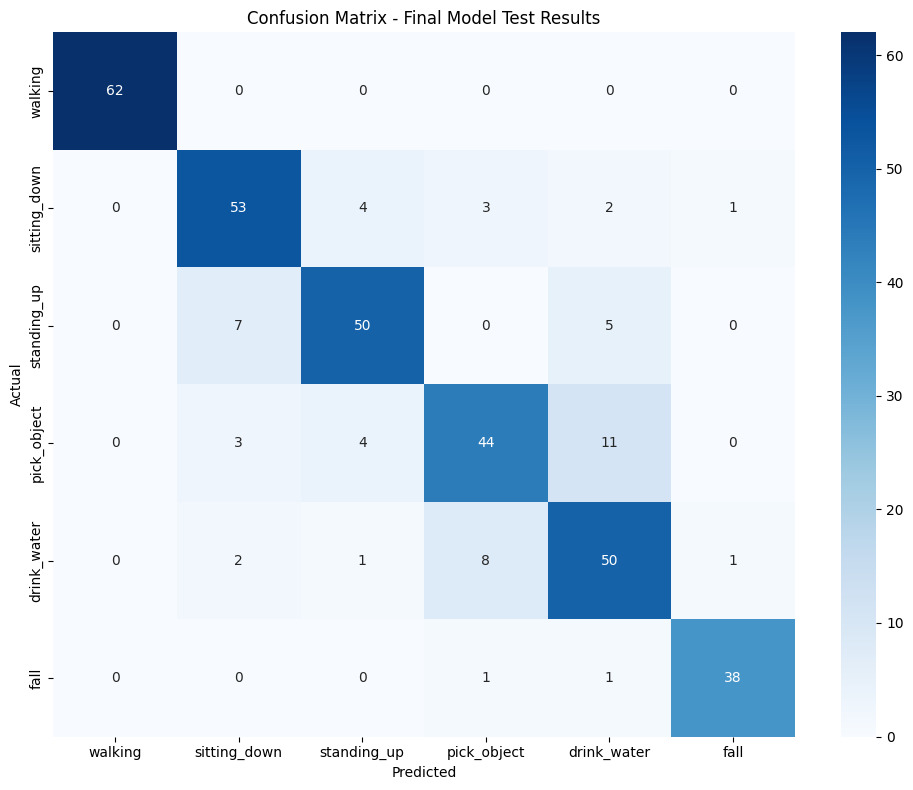


Final model saved to final_kfold_model.pth

SUMMARY
K-Fold CV Average Validation Accuracy: 0.8040 ± 0.0210
Final Model Test Accuracy: 0.8462
Number of classes: 6
Test set size: 351
Class distribution in test set: [62 63 62 62 62 40]


In [139]:
# Generate classification report
class_names = [str(cls) for cls in le.classes_]  # Convert to strings
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
ACTIVITY_MAP = {
    "walking": 1,
    "sitting_down": 2,
    "standing_up": 3,
    "pick_object": 4,
    "drink_water": 5,
    "fall": 6,
}
#use the ACTIVITY_MAP keys for labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ACTIVITY_MAP.keys(), yticklabels=ACTIVITY_MAP.keys())
plt.title('Confusion Matrix - Final Model Test Results')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_before.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Save final model
final_model_path = 'final_kfold_model.pth'
torch.save(final_model.state_dict(), final_model_path)
print(f"\nFinal model saved to {final_model_path}")

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"K-Fold CV Average Validation Accuracy: {np.mean(fold_results['val_accuracies']):.4f} ± {np.std(fold_results['val_accuracies']):.4f}")
print(f"Final Model Test Accuracy: {test_accuracy:.4f}")
print(f"Number of classes: {num_classes}")
print(f"Test set size: {len(X_test_tensor)}")
print(f"Class distribution in test set: {np.bincount(all_labels)}")